# Body Segmentation

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In video production, for example, in weather forecasts, we often need to cut out a human image from camera and place it on top of some other footage. This is typically done using **chroma key** techniques, when a human is filmed in front of a uniform color background, which is then removed. In this lab, we will train a neural network model to cut out the human silhouette.

We will be using [Segmentation Full Body MADS Dataset](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset) from Kaggle. Download the dataset manually from Kaggle and unzip in into current directory.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
import os
torch.manual_seed(42)
np.random.seed(42)

In [2]:
dataset_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img'

import os
import matplotlib.pyplot as plt

Let's see how images in the dataset look like:

In [3]:
img_path = os.path.join(dataset_path,'images')
mask_path = os.path.join(dataset_path,'masks')

fnames = os.listdir(img_path)

def load_image(img_name):
    img = plt.imread(os.path.join(img_path,img_name))
    mask = plt.imread(os.path.join(mask_path,img_name))
    return img,mask

(-0.5, 511.5, 383.5, -0.5)

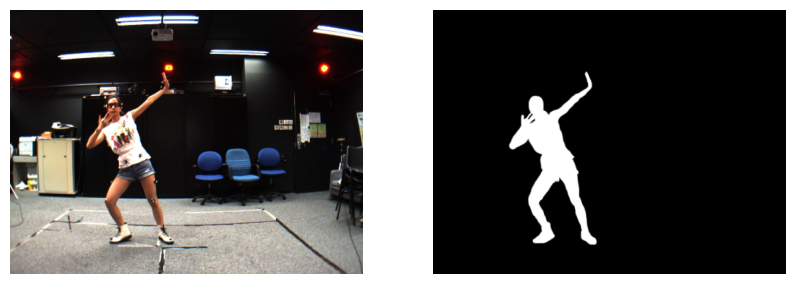

In [4]:
img, mask = load_image(fnames[5])

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')

# Kaleb's Implementation

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
weight_decay = 1e-6
batch_size = 32
epochs = 30

## Prep the data

In [6]:
# Load all images
images, masks = [],[]
for i in fnames: 
    X, y = load_image(i)
    images.append(X), masks.append(y)

In [ ]:
# Prep them
size = (256, 256)
# images = torch.permute(torch.FloatTensor(np.array([resize(image, size, mode='constant', anti_aliasing=True,) for image in images])), (0, 3, 1, 2))
# masks = torch.FloatTensor(np.array([resize(mask, size, mode='constant', anti_aliasing=False) > 0.5 for mask in masks])).unsqueeze(1)
masks_resized = []
for mask in masks:
    # If masks are RGB, convert to grayscale by taking one channel or averaging channels
    if mask.shape[-1] == 4:  # RGBA
            mask = mask[:, :, :3]  # Remove alpha channel
    if mask.ndim == 3 and mask.shape[-1] == 3: # RGB
        mask = mask[:, :, 0]  # or np.mean(mask, axis=-1) for averaging channels
    resized_mask = resize(mask, size, mode='constant', anti_aliasing=False) > 0.5
    masks_resized.append(resized_mask)
masks = torch.FloatTensor(np.array(masks_resized)).unsqueeze(1)

indices = np.random.permutation(range(len(images)))
train_size = int(train_size * len(images))
train_ind = indices[:train_size]
test_ind = indices[train_size:]

train_dataset = (images[train_ind, :, :, :], masks[train_ind, :, :, :])
test_dataset = (images[test_ind, :, :, :], masks[test_ind, :, :, :])

In [ ]:
print(size(train_dataset))
print(size(test_dataset))